In [1]:
# !pip install mvlearn==0.5.0 wordcloud==1.9.3 matplotlib==3.3.4 distinctipy==1.3.4 networkx==3.2.1  umap==0.1.1 hoggorm==0.13.3 adilsm==0.0.11 scikit-learn==1.1.2 scipy==1.9.1 numpy==1.23.3
# scipy==1.9.1 used (due to changes in SVDS in later versions) to reproduce presented results in ref paper
# scikit-learn==1.1.2 used (due to changes in MDS in later versions) to reproduce presented results in ref paper
# numpy==1.23.3 used (due to changes in ??? in later versions) to reproduce presented results in ref paper

In [2]:
# !pip install -e ..
# !pip list

In [3]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import adilsm.adilsm as ilsm
from adnmtf import NMF # type: ignore
from sklearn.linear_model import LinearRegression
import time

RESULTS_PATH = './results/'
DATA_PATH = './data/'

df = pd.read_csv(DATA_PATH + 'ALL-AML Brunet.csv')

# for Brunet only:
m0 = np.log2(df.values[:,2:].astype(np.float_))
(n,p) = np.shape(m0)
m0-=np.repeat(np.min(m0, axis=0)[:,np.newaxis].T, n, axis=0)

m0 = np.random.permutation(m0.T).T

# Enlarge matrix to better compare performance
m0 = np.vstack((m0, m0))
m0 = np.hstack((m0, m0))

(n,p) = np.shape(m0)

adilsm version=0.0.12


In [4]:
n_slices = 10
n_comp = 4
p_slice = int(p/n_slices)
Xs=[m0[:,i*p_slice:(i+1)*p_slice] for i in range(n_slices)]

In [5]:
# Perform standard NMF on whole matrix for comparison with ilsm
my_nmfmodel = NMF(n_components=n_comp, leverage=None, max_iter=200, tol=1.e-6, verbose=-1, random_state=0)

start_time = time.time()
estimator_ = my_nmfmodel.fit_transform(m0.copy())

w_nmf = estimator_.w
h_nmf = estimator_.h
end_time = time.time()
execution_time_nmf = end_time - start_time

In [6]:
# Perform ILSM on matrix slices
n_embedding, n_themes = [n_comp,n_comp]

start_time = time.time()
ilsm_result = ilsm.ilsm(Xs, n_embedding, n_themes, norm_columns=0, update_h_ism=True,
                                    max_iter_mult=200, fast_mult_rules=True, sparsity_coeff=.8, use_scikit_NMF=False)
hv = ilsm_result['HV']
hv_sparse = ilsm_result['HV_SPARSE']
hhii = ilsm_result['HHII']
w_ism = ilsm_result['W']
h_ism = ilsm_result['H']
q_ism = ilsm_result['Q']
Xs_emb = ilsm_result['EMBEDDING']
Xs_norm = ilsm_result['NORMED_VIEWS']

h_fnmf = np.empty((0, n_comp))
for i in range(n_slices):
    h_fnmf = np.vstack((h_fnmf, hv[i]))

# normalize w_ism and h_fnmf by max column in w_ism as in w_nmf
max_values = np.max(w_ism, axis=0)
w_fnmf = np.divide(w_ism, np.where(max_values == 0, 1, max_values))
h_fnmf = np.multiply(h_fnmf, max_values)

end_time = time.time()
execution_time_fnmf = (end_time - start_time)

# Calculate error
error = np.linalg.norm(m0 -  w_fnmf @ h_fnmf.T) / np.linalg.norm(m0)
print('error(fnmf): ',round(error, 2))
print('time(fnmf): ',round(execution_time_fnmf, 4))

error = np.linalg.norm(m0 -  w_nmf @ h_nmf.T) / np.linalg.norm(m0)
print('error(nmf): ',round(error, 2))
print('time(nmf): ',round(execution_time_nmf, 4))


error ism before straightening:  0.17
Straightening:
iteration 0...
iteration 1...
iteration 2...
error ism after straightening:  0.17
error ilsm:  0.41
error(fnmf):  0.41
time(fnmf):  3.3835
error(nmf):  0.4
time(nmf):  4.8886


error ism before straightening:  0.03
Straightening:
iteration 0...
iteration 1...
iteration 2...
error ism after straightening:  0.03


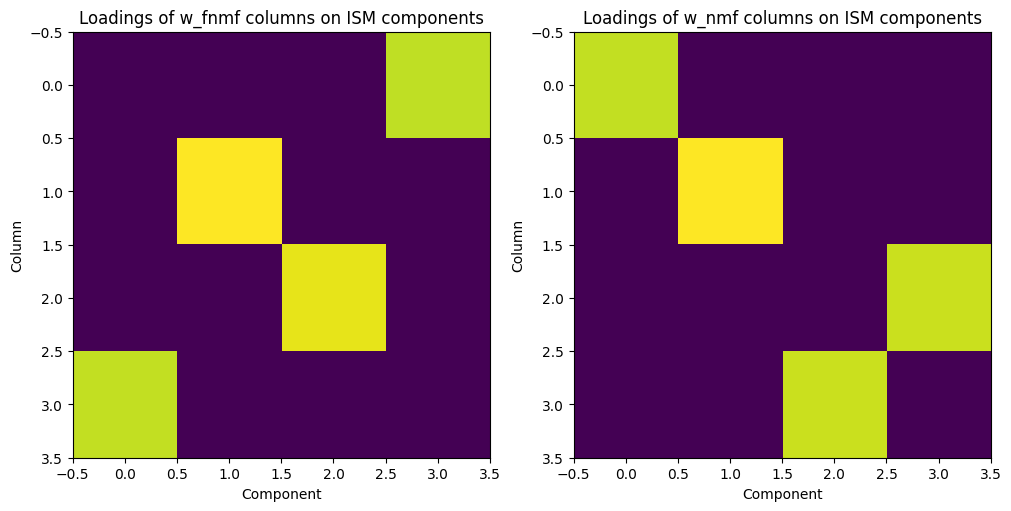

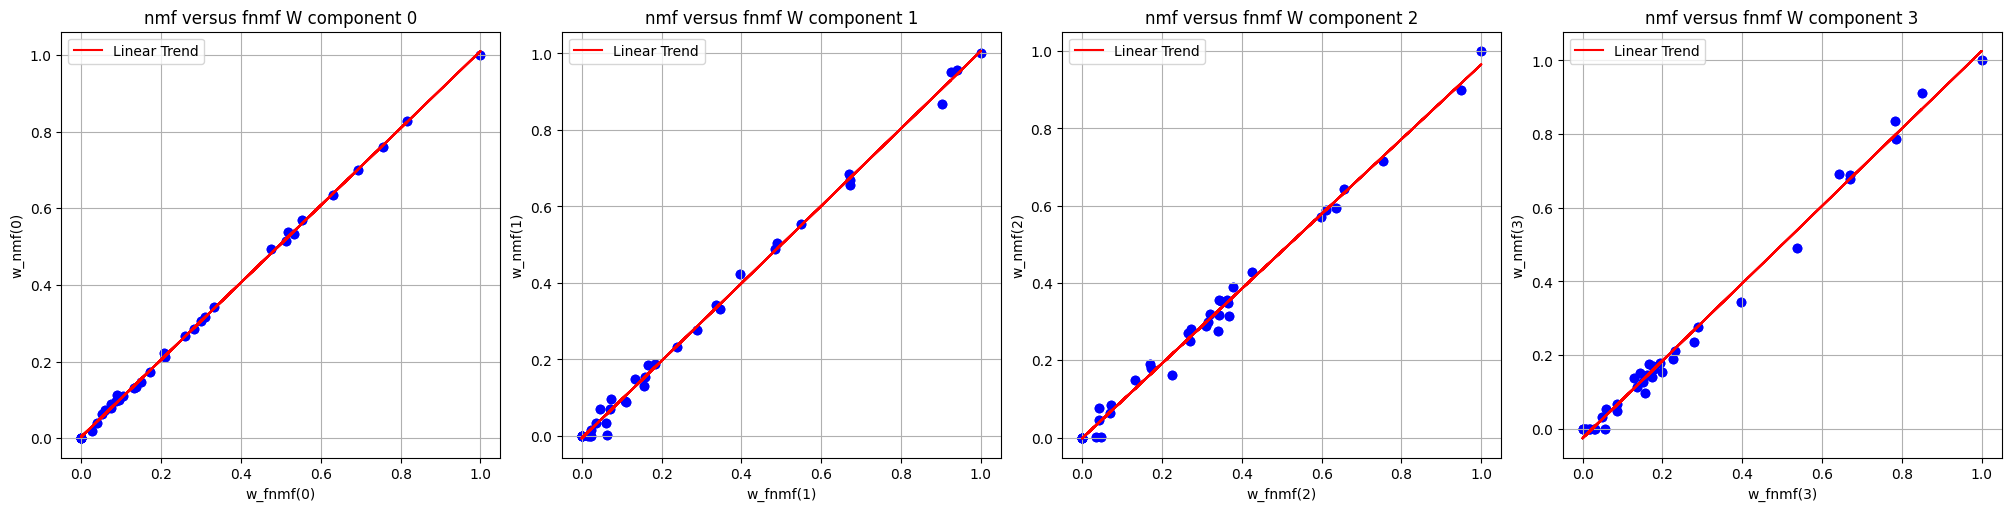

In [7]:
# Perform ISM on reduced matrices w_fnmf and w_nmf
# ISM is expected to recognize that w_fnmf and w_nmf convey the same information up to some noise,
# albeit with the columns of either matrix swapped around.
# Heatmaps of the loadings of w_fnmf and w_nmf columns on ISM components show the effective permutation. 

Xs = [w_fnmf, w_nmf]
n_embedding, n_themes = [n_comp,n_comp]

ilsm_result = ilsm.ism(Xs, n_embedding, n_themes, norm_columns=0, update_h_ism=True,
                                    max_iter_mult=200, fast_mult_rules=True, sparsity_coeff=.8)
hv = ilsm_result['HV']
hv_sparse = ilsm_result['HV_SPARSE']
hhii = ilsm_result['HHII']
w_ism = ilsm_result['W']
h_ism = ilsm_result['H']
q_ism = ilsm_result['Q']
Xs_emb = ilsm_result['EMBEDDING']
Xs_norm = ilsm_result['NORMED_VIEWS']

fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

ax[0].imshow(hv[0], cmap='viridis', aspect='auto')
# Add labels and title
ax[0].set_xlabel('Component')
ax[0].set_ylabel('Column')
ax[0].set_title('Loadings of w_fnmf columns on ISM components')

ax[1].imshow(hv[1], cmap='viridis', aspect='auto')
# Add labels and title
ax[1].set_xlabel('Component')
ax[1].set_ylabel('Column')
ax[1].set_title('Loadings of w_nmf columns on ISM components')

# Show the plot
plt.show()

# Apply back-permutation to obtain comparable components and plot scatterplot
w_fnmf_perm = w_fnmf[:,np.argmax(hv[0], axis=0)]
w_nmf_perm = w_nmf[:,np.argmax(hv[1], axis=0)]

regressor = LinearRegression()

fig, ax = plt.subplots(1, n_comp, figsize=(20, 5), constrained_layout=True)
for i in range(n_comp):
    regressor.fit(w_fnmf_perm[:,i].reshape(-1, 1), w_nmf_perm[:,i])
    ax[i].plot(w_fnmf_perm[:,i], regressor.predict(w_fnmf_perm[:,i].reshape(-1, 1)), color='r', label='Linear Trend')
    ax[i].scatter(w_fnmf_perm[:,i], w_nmf_perm[:,i], color='b')
    ax[i].set_xlabel('w_fnmf('+str(i)+')')
    ax[i].set_ylabel('w_nmf('+str(i)+')')
    ax[i].set_title('nmf versus fnmf W component '+str(i))
    ax[i].grid(True)
    ax[i].legend()

plt.show()